## Automatic Differentiation via Dual Numbers (forward mode) 🚀🚀🚀


In this Notebook, we explain Automatic Differentiation via Dual Numbers—an important and impressive trick where evaluating the function also evaluates its derivative at the same time. We implement Automatic Differentiation via Dual Numbers as described in [this paper]
(https://arxiv.org/pdf/1502.05767) and these amazing articles:
- [Dual Numbers & Automatic Differentiation](https://blog.demofox.org/2014/12/30/dual-numbers-automatic-differentiation/)
- [Automatic Differentiation: Dual Numbers](https://roberttlange.com/posts/2019/08/blog-post-6/)

So let's get started.

First of all, we have four types of differentiation:

### 1) Manual Differentiation
If you have f(x):
f(x) = 64x(1-x)(1-2x)^2(1-8x+8x^2)^2

Then you manually differentiate

f'(x) = 128x(1-x)(1-2x)^2(-8+16x)
       + 64(1-x)(1-2x)^2(1-8x+8x^2)^2
       + 64x(1-2x)^2(1-8x+8x^2)^2
       - 256x(1-x)(1-8x+8x^2)^2

This type is slow and prone to errors.

### 2) Numerical Differentiation
we compare diff errors in num diff.
f(x) = sin(x) at x = π/4
F'(x) ≈ (f(x+h) - f(x))/h

#### 1) Truncation error: h
using h = 0.1
F'(π/4) ≈ (sin(π/4 + 0.1) - sin(π/4))/0.1
True derivative = cos(π/4) = √2/2

The approximation introduces truncation error because it truncates higher order terms of Taylor expansion of sin(x) about x = π/4

#### 2) Round-off errors
suppose that values of sin(π/4 + 0.1) and sin(π/4) are calculated using floating point arithmetic, resulting in slightly inaccurate values due to finite representation of π, sin(x) and arithmetic operations


### 3) Symbolic Differentiation
This type has two disadvantages:
**Expression Swell**: It makes the expression large and complex.
The output is an expression, not an exact value that you can use directly in your calculations.

If f(x) = x^2  at  x = 2 ,
then f'(x) = 2x , not evaluated at any specific point even if you know the point.

### 4) Automatic Differentiation
Automatic differentiation solves all these issues. It's fast, applies the chain rule to complex expressions without human intervention, and evaluates the derivative with an exact value, not symbolically.

Let's revise the chain rule, which automatic differentiation depends on:

### Chain Rule

The chain rule for two functions $f(x)$ and $g(x)$ states that:

$$(f \circ g)'(x) = f'(g(x)) \cdot g'(x)$$

For example, if $f(x) = x^2$ and $g(x) = x + 2$, then:

$$f(x) = x^2$$
$$g(x) = x + 2$$

Applying the chain rule:

$$(f \circ g)'(x) = f'(g(x)) \cdot g'(x)$$

Substituting the functions:

$$(f \circ g)'(x) = 2(g(x)) \cdot 1 = 2(x + 2) \cdot 1 = 2(x + 2)$$

In [2]:
import numpy as np
import pandas as pd

In [3]:
# create my CustomError class to handle 0 raised to dualNumber

class custom_math_error(ArithmeticError):
    def __init__(self,message="zero raised to dual number error !"):
        super().__init__(message)



In [4]:
# create DualNumber Class
class DualNumber (object):
    def __init__ (self,real:float,dual:float=0.0):
        self.real = real
        self.dual = dual
    def __repr__(self):
        return f"DualNumber(real={self.real},dual={self.dual})"
    # overloading operators :
    # -----------------------
    # overload basic operations like (+,-,/,*)
    # Example : Addition (a + b) :
    # When DualNumber is the left operand use   __add__
    # When DualNumber is the right operand use  __radd__

    def __add__(self,other):
        if isinstance(other,DualNumber):
            return DualNumber(self.real+other.real, self.dual+other.dual)
        else :
            return DualNumber(self.real + other , self.dual)

    def __radd__(self,other):
        return self.__add__(other)

    def __sub__(self,other):
        if isinstance(other,DualNumber):
            return DualNumber(self.real- other.real, self.dual-other.dual)
        else :
            return DualNumber(self.real - other , self.dual)

    def __rsub__(self,other):
        return DualNumber(other - self.real, - self.dual)

    def __pow__(self,other):
       if self.real == 0 and other.real == 0 :
           raise custom_math_error()
       if self.real == 0 and other.real != 0 :
           return DualNumber(0)
       if isinstance(other,DualNumber):
            return DualNumber(np.power(self.real,other.real) ,(self.dual * other.real *np.power(self.real,float(other.real - 1)))+
                  (np.log(self.real)*np.power(self.real,other.real)*other.dual))
       else :
            return DualNumber(np.power(self.real,other.real) ,(self.dual*other.real*np.power(self.real,float(other.real -1))) )

    # dual number here is the exponent
    # the scalar is the base
    # no need to check isinstance
    # Example : scalar (x) and dual number (y) = a + b epsilon
    # y real part = a
    # y dual part = b
    # the operation is (x ** y)
    # with the rules of logarithms and exponentiation :
    # x^y = x ^ ( a + b epsilon) = x^a + (b ln x) epsilon

    # when the operation is reversed the other operand become the base
    def __rpow__(self, base):
        if base == 0 and self.real == 0:
            raise custom_math_error("0 cannot be raised to the power of 0")
        new_real = np.power(float(base), self.real)
        new_dual = new_real * np.log(float(base)) * self.dual
        return DualNumber(new_real, new_dual)

    def __mul__(self,other):
      if isinstance(other,DualNumber):
        return DualNumber(self.real*other.real ,(self.real*other.dual + self.dual*other.real ) )
      else :
        return DualNumber(other*self.real,other*self.dual)

    def __rmul__(self,other):
        return self.__mul__(other)

    def log(self) :
      if (self.real <= 0):
        raise ValueError("Logarithm only defined for positive real part")
      return DualNumber(np.log(self.real),self.dual/self.real)

    def exp (self):
      return DualNumber(np.exp(self.real),self.dual*np.exp(self.real))


    # trig functions
    # ---------------
    def sin(self):
      return DualNumber(np.sin(self.real),np.cos(self.real)*self.dual)

    def cos(self):
      return DualNumber(np.cos(self.real),np.sin(self.real)*self.dual*-1)

    def tan(self):
      return DualNumber(np.tan(self.real), self.dual / (np.cos(self.real) ** 2  ))
    # Hyperbolic functions :
    # ------------------------
    def sinh(self):
      return (np.sinh(self.real),self.dual*np.cosh(self.real))

    def cosh(self):
      return (np.cosh(self.real),self.dual*np.sinh(self.real))

    def tanh(self):
      return (np.tanh(self.real), self.dual / (np.cosh(self.real)**2))

    def sigmoid(self):
        sigmoid_real = 1 / (1 + np.exp(-self.real))
        sigmoid_dual = sigmoid_real * (1 - sigmoid_real) * self.dual
        return DualNumber(sigmoid_real, sigmoid_dual)






**Testing the DualNumber class**

In [15]:
# Example usage
a = DualNumber(3, 2)
b = DualNumber(4, 1)
c = 2

# Test addition
print("Test addition")
print(a + b)  # Expected: DualNumber(real=7, dual=3)
print(a + c)  # Expected: DualNumber(real=5, dual=2)
print(c + a)  # Expected: DualNumber(real=5, dual=2)

# Test subtraction
print("Test subtraction")
print(a - b)  # Expected: DualNumber(real=-1, dual=1)
print(a - c)  # Expected: DualNumber(real=1, dual=2)
print(c - a)  # Expected: DualNumber(real=-1, dual=-2)

# Test multiplication
print("Test multiplication")
print(a * b)  # Expected: DualNumber(real=12, dual=10)
print(a * c)  # Expected: DualNumber(real=6, dual=4)
print(c * a)  # Expected: DualNumber(real=6, dual=4)

# Test power
print("Test power")
print(a ** b)  # Expected: DualNumber(real=81, dual=162)
print(a ** c)  # Expected: DualNumber(real=9, dual=12)
print(c ** a)  # Expected: DualNumber(real=8, dual=16.635532333438686)

# Example usage
a = DualNumber(np.pi / 4, 1.0)

# Sine of a dual number
result_sin = a.sin()
print(f"sin(a) = {result_sin}")  # Expected: DualNumber(real=sin(pi/4), dual=cos(pi/4))

# Cosine of a dual number
result_cos = a.cos()
print(f"cos(a) = {result_cos}")  # Expected: DualNumber(real=cos(pi/4), dual=-sin(pi/4))

# Tangent of a dual number
result_tan = a.tan()
print(f"tan(a) = {result_tan}")


def f(x):
  return x**2 + 2*x + 10

input_value = 5.0
x = DualNumber(input_value,1.0)

result = f(x)

print("real = ",result.real," dual = ",result.dual)

Test addition
DualNumber(real=7,dual=3)
DualNumber(real=5,dual=2)
DualNumber(real=5,dual=2)
Test subtraction
DualNumber(real=-1,dual=1)
DualNumber(real=1,dual=2)
DualNumber(real=-1,dual=-2)
Test multiplication
DualNumber(real=12,dual=11)
DualNumber(real=6,dual=4)
DualNumber(real=6,dual=4)
Test power
DualNumber(real=81,dual=304.98759538211687)
DualNumber(real=9,dual=12.0)
DualNumber(real=8.0,dual=11.090354888959125)
sin(a) = DualNumber(real=0.7071067811865475,dual=0.7071067811865476)
cos(a) = DualNumber(real=0.7071067811865476,dual=-0.7071067811865475)
tan(a) = DualNumber(real=0.9999999999999999,dual=1.9999999999999996)
real =  45.0  dual =  12.0


**Gradient Descent to optimize loss function using DualNumber**

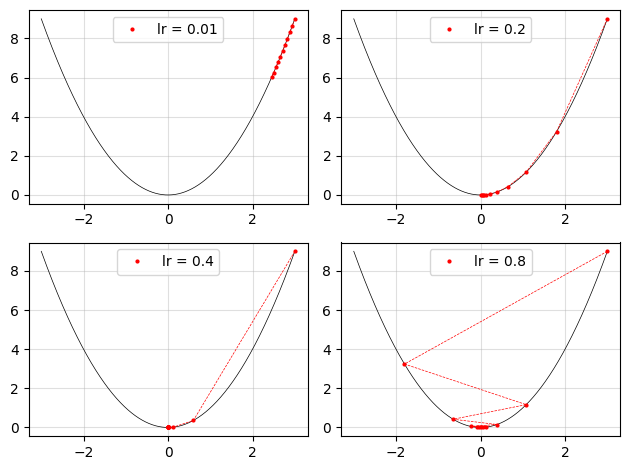

In [14]:
"""Automatic differentiation and gradient descent with dual numbers.

Toy example performs and visualizes gradient descent with dual numbers.
"""


def plot_curve(axes, x_min=-3.0, x_max=3.0):
    """Plots loss landscape."""

    style_dict = dict(color="black", alpha=1.0, linewidth=0.5)

    for axis in axes.flatten():
        pred = np.linspace(x_min, x_max, num=1000)
        loss = pred**2
        axis.plot(pred, loss, **style_dict)


class Model:
    """Toy model with single scalar weight."""

    def __init__(self, weight_init: float = 1.0):
        self.weight = DualNumber(real=weight_init, dual=1.0)
        self.grad = 0.0

    def forward(self, data: float = 1.0):
        """Basic forward method.

        Data can be considered as constant one.
        """
        return data * self.weight

    def loss(self, data: float = 1.0):
        """Squared error loss function."""
        out = (0.0 - self.forward(data))**2
        if isinstance(out, DualNumber):
            self.grad = out.dual
            return out.real
        else:
            out

def gradient_descent(weight_init, n_steps, learning_rate, keep_every_n_steps=1):
    """Method performs gradient descent."""

    # Initializing dual number with dual part set to 1.
    model = Model(weight_init=weight_init)

    weight_hist = []
    weight_hist.append(model.weight.real)

    for i in range(n_steps):

        # Forward and loss computation.
        # Gradients are automatically computed.
        model.loss()

        # Gradient descent
        model.weight = model.weight - learning_rate * model.grad

        if (i + 1) % keep_every_n_steps == 0:
            weight_hist.append(model.weight.real)

    return np.array(weight_hist)


def main():
    """Main method for gradient descent with dual numbers."""

    n_steps = 10
    weight_init = 3.0
    keep_every_n_steps = 1

    fig, axes = plt.subplots(nrows=2, ncols=2)

    plot_curve(axes)

    learning_rates = [0.01, 0.2, 0.4, 0.8]
    for learning_rate, axis in zip(learning_rates, axes.flatten()):
        weight_hist = gradient_descent(
            weight_init=weight_init,
            n_steps=n_steps,
            learning_rate=learning_rate,
            keep_every_n_steps=keep_every_n_steps
        )
        label = f"lr = {learning_rate}"
        axis.plot(weight_hist, weight_hist**2, "ro", markersize=2.0, label=label)
        axis.plot(weight_hist, weight_hist**2, "r--", linewidth=0.5)
        axis.legend()
        axis.grid(alpha=0.4)

    plt.tight_layout()
    plt.show()
    # plt.savefig("gradient_descent_visualization.png", dpi=90)
    plt.close(fig)


if __name__ == "__main__":
    main()